## 开始训练

### 导入必要的包

In [1]:
import os
import cv2
import tensorflow as tf
from time import time
import vgg16model as model
import utils
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder


print('GPU is', 'available' if tf.test.is_gpu_available() else 'Not available')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

GPU is available


### 开始训练

In [2]:
tf.reset_default_graph()

file_dir = 'data/train/'

train_steps = 200
startTime = time()
batch_size = 50
capacity = 256
means = [123.68, 116.779, 103.939]
xs, ys = utils.get_file(file_dir)

image_batch, label_batch = utils.get_batch(xs, ys, 224, 224, batch_size, capacity)

x = tf.placeholder(tf.float32, [None, 224, 224, 3])
y = tf.placeholder(tf.int32, [None, 2])

encoder = OneHotEncoder(sparse=False)
one_hot = [[0],[1]]
encoder.fit(one_hot)
vgg = model.vgg16(x)
fc8_finetuining = vgg.probs
loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc8_finetuining, labels=y))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(fc8_finetuining, 1),
                   tf.argmax(y, 1)),'float32'))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss_function)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

log_dir = './dogs_vs_cats_log/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
writer = tf.summary.FileWriter(log_dir, sess.graph)

image_shape_input = tf.reshape(x, [-1, 224, 224, 1])
tf.summary.image('input', image_shape_input, 9)
tf.summary.histogram('forward', fc8_finetuining)
tf.summary.scalar('loss', loss_function)
tf.summary.scalar('accuracy', accuracy)
merged_summary_op = tf.summary.merge_all()


ckpt_dir = 'local_model'
ckpt = tf.train.latest_checkpoint(ckpt_dir)
saver = tf.train.Saver()
if ckpt != None:
    saver.restore(sess, ckpt)
    print('----------------------checkpoint model loaded----------------------')
else:
    vgg.load_weights('./vgg16_weights.npz', sess)

saver = tf.train.Saver(max_to_keep = 5)

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=sess)


start = sess.run(vgg.step)
print("Training starts from {} step.".format(start + 1))

loss_list = []
accuracy_list = []

for i in range(start, train_steps):
    images, labels = sess.run([image_batch, label_batch])
    
    labels = labels.reshape(-1, 1)
    labels = encoder.transform(labels)

    sess.run(optimizer, feed_dict={x:images, y:labels})
    summary_str, loss, acc = sess.run([merged_summary_op, loss_function, accuracy], feed_dict={x:images, y:labels})


    print("Train Step:", '%02d' % (i + 1), "Loss=", "{:.6f}".format(loss), "Accuracy=", acc)
    writer.add_summary(summary_str, i)
    
    loss_list.append(loss)
    accuracy_list.append(acc)

    if (i + 1) % 10 == 0:
        sess.run((vgg.step).assign(i + 1))
        saver.save(sess, os.path.join("./local_model/", 'step_{:03d}.ckpt'.format(i + 1)))
        print("./local_model/", 'step_{:03d}.ckpt saved!'.format(i + 1))      

duration = time() - startTime
print("Train Finished takes:", "{:.2f}".format(duration))

coord.request_stop()
coord.join(threads)

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(tuple(tensor_list)).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.range(limit).shuffle(limit).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To 

./model/ step_060.ckpt saved!
Train Step: 61 Loss= 0.547337 Accuracy= 0.66
Train Step: 62 Loss= 0.568271 Accuracy= 0.66
Train Step: 63 Loss= 0.575320 Accuracy= 0.52
Train Step: 64 Loss= 0.600799 Accuracy= 0.52
Train Step: 65 Loss= 0.570325 Accuracy= 0.56
Train Step: 66 Loss= 0.545811 Accuracy= 0.68
Train Step: 67 Loss= 0.581391 Accuracy= 0.56
Train Step: 68 Loss= 0.581581 Accuracy= 0.58
Train Step: 69 Loss= 0.550933 Accuracy= 0.62
Train Step: 70 Loss= 0.595417 Accuracy= 0.52
./model/ step_070.ckpt saved!
Train Step: 71 Loss= 0.549911 Accuracy= 0.64
Train Step: 72 Loss= 0.642595 Accuracy= 0.36
Train Step: 73 Loss= 0.581996 Accuracy= 0.56
Train Step: 74 Loss= 0.555806 Accuracy= 0.6
Train Step: 75 Loss= 0.569716 Accuracy= 0.62
Train Step: 76 Loss= 0.513859 Accuracy= 0.74
Train Step: 77 Loss= 0.553674 Accuracy= 0.62
Train Step: 78 Loss= 0.566584 Accuracy= 0.6
Train Step: 79 Loss= 0.535141 Accuracy= 0.7
Train Step: 80 Loss= 0.573633 Accuracy= 0.56
./model/ step_080.ckpt saved!
Train Step: 8

### 训练可视化

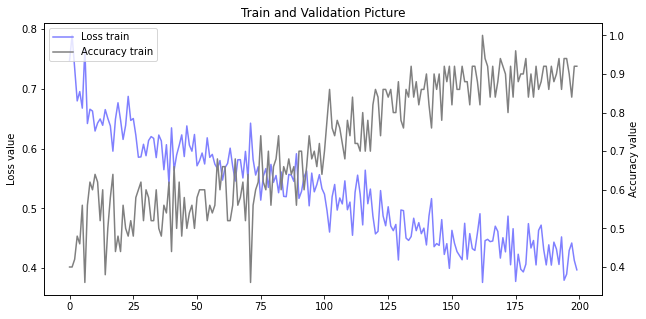

In [7]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
ax1 = fig.add_subplot(111)
ax1.set_title('Train and Validation Picture')
ax1.set_ylabel('Loss value')
line1, = ax1.plot(loss_list, color=(0.5, 0.5, 1.0), label='Loss train')
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy value')
line2, = ax2.plot(accuracy_list, color=(0.5, 0.5, 0.5), label='Accuracy train')
plt.legend(handles=(line1, line2), loc='best')
plt.show()

### 单张预测

Model restoring...
INFO:tensorflow:Restoring parameters from local_model\step_200.ckpt
This is a cat with possibility 0.999851


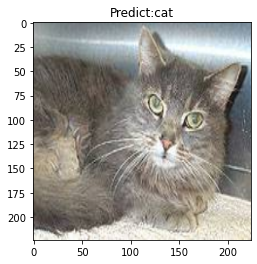

In [20]:
tf.reset_default_graph()

means = [123.68, 116.779, 103.939]
x = tf.placeholder(tf.float32, [None, 224, 224, 3])

sess = tf.Session()
vgg = model.vgg16(x)
fc8_finetuining = vgg.probs

saver = tf.train.Saver()
ckpt_dir = 'local_model'
ckpt = tf.train.latest_checkpoint(ckpt_dir)
print("Model restoring...")
#saver.restore(sess, './local_model/step_xxx.ckpt')
saver.restore(sess, ckpt)

filepath = 'data/test1/7.jpg'
img = cv2.imread(filepath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img.astype(np.float32)
IMG = img.copy()

for c in range(3):
    img[:, :, c] -= means[c]
prob = sess.run(fc8_finetuining, feed_dict={x: [img]})
max_index = np.argmax(prob)

if max_index == 0:
    cls_name = 'cat'
    print("This is a cat with possibility %.6f" % prob[:, 0])
else:
    cls_name = 'dog'
    print("This is a dog with possibility %.6f" % prob[:, 1])

sess.close()

plt.imshow(IMG.astype('uint8'))
plt.title('Predict:' + cls_name)
plt.show()

### 多张预测




Model restoring...
INFO:tensorflow:Restoring parameters from local_model\step_200.ckpt


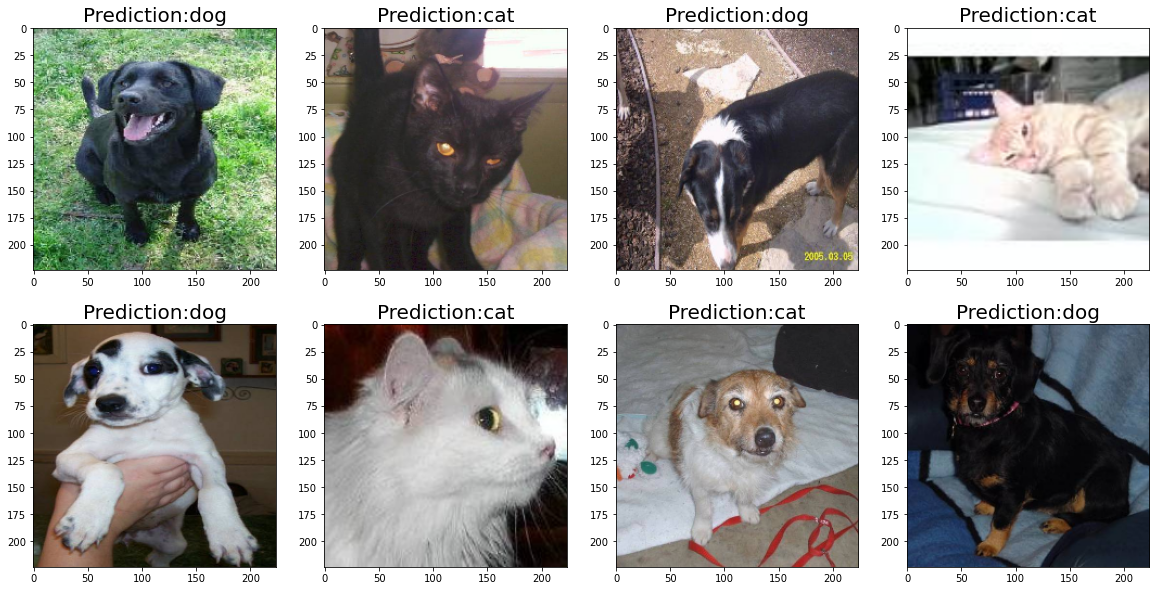

In [2]:
tf.reset_default_graph()

means = [123.68, 116.779, 103.939]
x = tf.placeholder(tf.float32, [None, 224, 224, 3])

sess = tf.Session()
vgg = model.vgg16(x)
fc8_finetuining = vgg.probs

saver = tf.train.Saver()
ckpt_dir = 'local_model'
ckpt = tf.train.latest_checkpoint(ckpt_dir)
print("Model restoring...")
#saver.restore(sess, './local_model/step_xxx.ckpt')
saver.restore(sess, ckpt)


file_i = np.random.randint(12500, size=(1, 8))
filepath = []
plt_images = []
pre_images = []
root_dir = 'data/test1/'
for i in range(file_i.shape[1]):
    filepath.append(root_dir + str(file_i[0][i]) + '.jpg')
    
for path in filepath:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32)
    IMG = img.copy()
    plt_images.append(IMG)
    del IMG

    for c in range(3):
        img[:, :, c] -= means[c]
    pre_images.append(img)

image_batch = np.array(pre_images)
prob = sess.run(fc8_finetuining, feed_dict={x: image_batch})
max_index = np.argmax(prob, 1)

sess.close()

fig = plt.gcf()
fig.set_size_inches(20, 10)
for i in range(8):
    if max_index[i] == 0:
        cls_name = 'cat'
    else:
        cls_name = 'dog'
    ax = plt.subplot(2, 4, 1 + i)
    ax.imshow(plt_images[i].astype('uint8'), cmap='binary')
    title = 'Prediction:' + cls_name
    ax.set_title(title, fontsize=20)
plt.show()